<a href="https://colab.research.google.com/github/azarkiel/PercepcionComputacional/blob/main/Actividad3_segmentadores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Actividad 3: Evaluación de la segmentación
#### Autor: Francisco Rubén Arenas Hernán

El objetivo de esta actividad es la segmentación, que consiste en detectar regiones homogéneas y aislar/detectar objetos dentro de una imagen. Estas regiones habitualmente corresponden a los objetos que se quieren identificar o disociar. Concretamente la actividad trata sobre métodos de segmentación de imágenes de monedas colocadas sobre un fondo oscuro. Para ello se han seleccionado cinco imágenes con estas características, encontradas a través del buscador google. Los métodos implementados han sido creados a partir de la documentación oficial de scikit-image para métodos de segmentación (Scikit-learn team, 2018) y a partir de los conocimientos y herramientas estudiados en las actividades anteriores de esta materia. La evaluación de la segmentación ha sido desarrollada a partir de la documentación oficial de scikit-image para métricas de evaluación, concretamente para el indice Jaccard (Jiancheng, L., & Scikit-learn team, 2015).
<p>Para el desarrollo de esta tercera actividad se han estudiado y construido tres métodos de segmentación diferentes: 

1.   ``método de segmentación basado en umbralización``
2.   ``método de segmentación basado en regiones``
3.   ``método de segmentación basado en contornos``

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import data, exposure 
from skimage.exposure import histogram
from skimage.color import rgb2gray
from skimage.color import rgb2grey
%matplotlib inline

## ``Adquisición de imágenes``
Las cinco imagenes seleccionadas se han escogido a través de búsquedas por internet. Las imágenes muestran monedas colocadas sobre un fondo oscuro. Para facilitar el envío y manipulación del notebook por parte del equipo docente se ha optado por la descarga de las imágenes desde el propio notebook. Así, todas las imágenes se cargan en memoria con el comando curl a partir sus URLs, de forma análoga a las anteriores actividades presentadas. Los nombres de ficheros se han almacenado en una tupla para facilitar el empleo de este notebook.

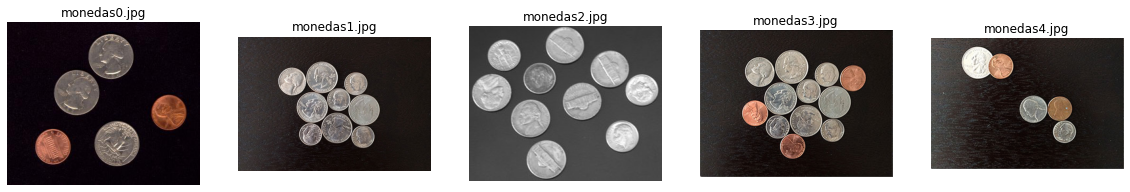

In [2]:
!curl -s -o monedas0.jpg https://johnloomis.org/ece563/notes/BinaryImages/coins/coins3.jpg
!curl -s -o monedas1.jpg https://pyimagesearch.com/wp-content/uploads/2015/10/watershed_coins_01.jpg
!curl -s -o monedas2.jpg https://i.stack.imgur.com/fDUGQ.jpg
!curl -s -o monedas3.jpg https://media.cheggcdn.com/media/f11/f1168b85-30e0-43dd-ad3d-6770a4517193/phpHqs22Y.png
!curl -s -o monedas4.jpg https://media.cheggcdn.com/media/9f8/9f8cf283-1d7b-4c6a-8727-8cf82a04b67f/php9D7V86.png
imagenes = ['monedas0.jpg','monedas1.jpg','monedas2.jpg','monedas3.jpg','monedas4.jpg']

plt.figure(figsize=(20,10))
plt.subplot(1,5,1),plt.imshow(io.imread(imagenes[0]));plt.title('monedas0.jpg'), plt.axis('off')
plt.subplot(1,5,2),plt.imshow(io.imread(imagenes[1]));plt.title('monedas1.jpg'), plt.axis('off')
plt.subplot(1,5,3),plt.imshow(io.imread(imagenes[2]));plt.title('monedas2.jpg'), plt.axis('off')
plt.subplot(1,5,4),plt.imshow(io.imread(imagenes[3]));plt.title('monedas3.jpg'), plt.axis('off')
plt.subplot(1,5,5),plt.imshow(io.imread(imagenes[4]));plt.title('monedas4.jpg'), plt.axis('off')
plt.show()

Las imágenes de ``GroundTruth`` empleadas para la evaluación de los segmentadores han sido editadas manualmente empleando la herramienta online Photopea (XXXX). Estas imágenes se han almacenado en un repositorio personal de GitHub, para permitir ser cargadas en caliente por este notebook sin necesidad de almacenarlas manualmente. Los nombres de las imágenes se han almacenado en una lista ordenadas según la lista de ``imagenes``. De esta forma, variando el valor de ``indiceImagen`` se permite acceder de forma simplificada tanto a la imagen de monedas a tratar, como a su correspondiente GroundTruth.

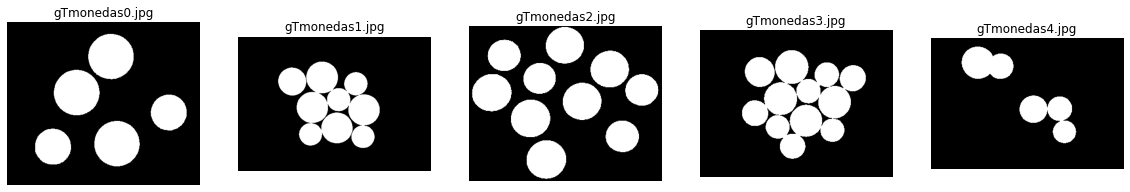

In [3]:
!curl -s -o gTmonedas0.jpg https://raw.githubusercontent.com/azarkiel/PercepcionComputacional/main/groundthruth/gt_monedas0.jpg
!curl -s -o gTmonedas1.jpg https://raw.githubusercontent.com/azarkiel/PercepcionComputacional/main/groundthruth/gt_monedas1.jpg
!curl -s -o gTmonedas2.jpg https://raw.githubusercontent.com/azarkiel/PercepcionComputacional/main/groundthruth/gt_monedas2.jpg
!curl -s -o gTmonedas3.jpg https://raw.githubusercontent.com/azarkiel/PercepcionComputacional/main/groundthruth/gt_monedas3.jpg
!curl -s -o gTmonedas4.jpg https://raw.githubusercontent.com/azarkiel/PercepcionComputacional/main/groundthruth/gt_monedas4.jpg
imgsGroundTruth = ['gTmonedas0.jpg','gTmonedas1.jpg','gTmonedas2.jpg','gTmonedas3.jpg','gTmonedas4.jpg']

plt.figure(figsize=(20,10))
plt.subplot(1,5,1),plt.imshow(io.imread(imgsGroundTruth[0]));plt.title('gTmonedas0.jpg'), plt.axis('off')
plt.subplot(1,5,2),plt.imshow(io.imread(imgsGroundTruth[1]));plt.title('gTmonedas1.jpg'), plt.axis('off')
plt.subplot(1,5,3),plt.imshow(io.imread(imgsGroundTruth[2]));plt.title('gTmonedas2.jpg'), plt.axis('off')
plt.subplot(1,5,4),plt.imshow(io.imread(imgsGroundTruth[3]));plt.title('gTmonedas3.jpg'), plt.axis('off')
plt.subplot(1,5,5),plt.imshow(io.imread(imgsGroundTruth[4]));plt.title('gTmonedas4.jpg'), plt.axis('off')
plt.show()

A continuación se lee la imagen a tratar de la lista de ``imagenes`` creada. Para probar con diferentes imágenes bastará con cambiar el valor de la variable ``indiceImagen`` por un valor entre ``0 y 4``. Con el cambio del valor de la variable se permite ejecutar todo el script para otra imagen diferente, sin tener que hacer ninguna otra modificación. Además, como paso preparatorio, la imagen se convierte a escala de grises manteniendo el rango de valores entre ``0-255``.

In [4]:
indiceImagen = 1  # Para probar otras imagenes cambiar el indice por 0,1,2,3 o 4.
imagenOriginal = io.imread(imagenes[indiceImagen])
monedas = (rgb2grey(imagenOriginal)*256).astype('uint8')

## ``1. Método basado en umbralización``

El método basado en umbralización es el método más simple para segmentar imágenes. Se basa en la aplicación de un valor umbral para dividir la imagen en fondo y frente. El valor umbral óptimo es dependiente de los tonos de grises que posean el fondo y las monedas. Para poder determinarlo se ha estudiado el histograma de cada imagen. Asím para cada imagen probada se ha escogido un valor umbral óptimo situado dentro del histograma en un punto intermedio entre la montaña correspondiente al fondo y la correspondiente a las monedas. Por lo tanto, para cada imagen se ha establecido su propio valor umbral óptimo. Todos los valores se han almacenado en la lista ``valorUmbral``. Hay que indicar que este método presetna el inconveniente de que puede obviar ciertas partes significativas de las monedas o incluso fusionar partes del fondo con las monedas.



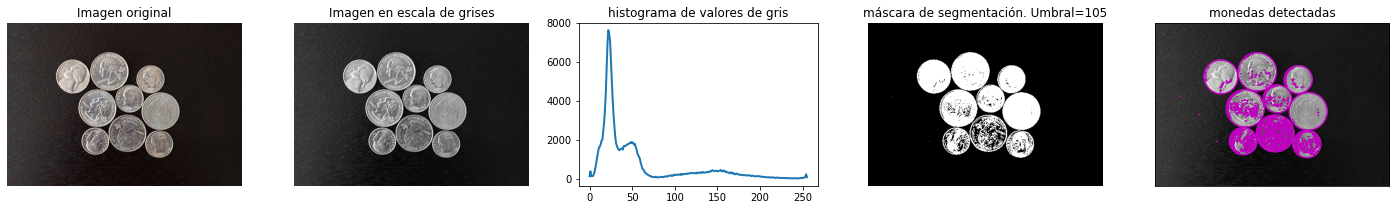

In [5]:
hist, hist_centers = histogram(monedas)
valorUmbral = [30, 105, 85, 80, 115] # Esta lista contiene el valor umbral para cada una de las imágenes
mascaraUmbralizacion = monedas > valorUmbral[indiceImagen] # Esta máscara será la que utilicemos en la evaluación

plt.figure(figsize=(30,3))
plt.subplot(1,6,1),plt.imshow(imagenOriginal);plt.title('Imagen original'), plt.axis('off')
plt.subplot(1,6,2),plt.imshow(monedas, cmap=plt.cm.gray);plt.title('Imagen en escala de grises'), plt.axis('off')
plt.subplot(1,6,3),plt.plot(hist_centers, hist, lw=2);plt.title('histograma de valores de gris')
plt.subplot(1,6,4),plt.imshow(mascaraUmbralizacion, cmap=plt.cm.gray);plt.title("máscara de segmentación. Umbral="+str(valorUmbral[indiceImagen])), plt.axis('off') #Se obtiene el valor umbral de la lista de valores umbrales establecida
plt.subplot(1,6,5),plt.imshow(monedas, cmap=plt.cm.gray),plt.contour(mascaraUmbralizacion, [0.5], linewidths=1.4, colors='m');plt.title('monedas detectadas'), plt.xticks([]), plt.yticks([])
plt.show()

## ``2. Segmentación basada en contornos``

A continuación se incluye el método implementado para delinear los bordes de las monedas utilizando segmentación basada en contornos. Los pasos que se han seguido son los siguientes:
1.   Obtención de bordes mediante el detector de bordes Canny.
2.   Rellenado mediante operaciones morfológicas de los contornos detectados.
3.   Eliminacion de artefactos espúreos con tamaño mínimo = 22, en caso de existir.

Como se puede ver en la imagen de la máscara de segmentación, los pequeños objetos espureos se eliminan fácilmente estableciendo un tamaño mínimo para los objetos válidos. Sin embargo, este método no es muy robusto ya que, tal y como se observa por ejemplo con la imagen ``monedas2.jpg``, elimina ciertas partes relevantes de las monedas y no se rellenan correctamente los contornos que no están cerrados perfectamente.


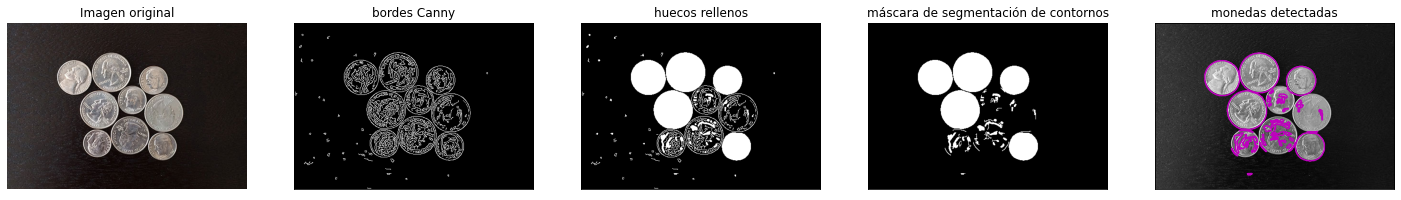

In [6]:
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage.filters import sobel
from skimage import morphology
from skimage import segmentation

bordesCanny = canny(monedas)
monedasRellenadas = ndi.binary_fill_holes(bordesCanny)
mascaraContornos = morphology.remove_small_objects(monedasRellenadas, 22) # Esta máscara será la que utilicemos en la evaluación

plt.figure(figsize=(30,20))
plt.subplot(1,6,1),plt.imshow(imagenOriginal, cmap=plt.cm.gray);plt.title('Imagen original'), plt.axis('off')
plt.subplot(1,6,2),plt.imshow(bordesCanny, cmap=plt.cm.gray);plt.title('bordes Canny'), plt.xticks([]), plt.yticks([])
plt.subplot(1,6,3),plt.imshow(monedasRellenadas, cmap=plt.cm.gray);plt.title('huecos rellenos'), plt.xticks([]), plt.yticks([])
plt.subplot(1,6,4),plt.imshow(mascaraContornos, cmap=plt.cm.gray);plt.title('máscara de segmentación de contornos'), plt.xticks([]), plt.yticks([])
plt.subplot(1,6,5),plt.imshow(monedas, cmap=plt.cm.gray),plt.contour(mascaraContornos, [0.5], linewidths=1.4, colors='m');plt.title('monedas detectadas'), plt.xticks([]), plt.yticks([])
plt.show()

## ``3. Segmentación basada en regiones``
A continuación se describe la implementado de un método basado en regiones. PAra ello se ha empleado el algoritmo ``Watershed`` presente en la libería scikit-image. Los pasos implementados para este método son los siguientes:
1. Creación de mapa de elevaciones utilizando el gradiente de Sobel de la imagen de las monedas. 
2. Detección de los marcadores del fondo y las monedas basadas en las partes extremas del histograma de valores de grises de la imagen. Para todas las imágenes se ha establecido como valor mínimo ``20`` y como valor máximo ``150``, ya que son dos valores que funcionan correctamente con las cinco imágenes seleccionadas.
3. Rellenado del mapa de elevaciones mediante el algoritmo Watershed y a partir de los marcadores detectados en el paso anterior.

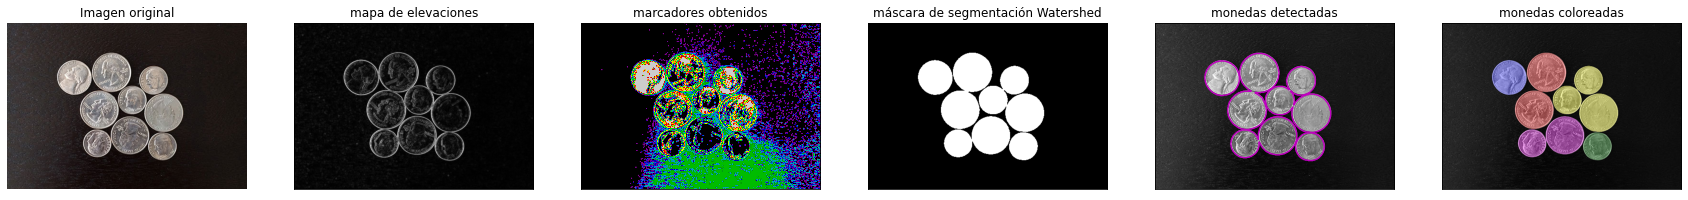

In [7]:
from skimage.color import label2rgb

mapaDeElevacion = sobel(monedas)

marcadores = np.zeros_like(monedas)
marcadores[monedas < 20] = 1
marcadores[monedas > 150] = 2

mascaraWatershed = segmentation.watershed(mapaDeElevacion, marcadores) #Esta es la máscara que utilizaremos en la evaluación

mascaraWatershed = ndi.binary_fill_holes(mascaraWatershed - 1)
monedasEtiquetadas, _ = ndi.label(mascaraWatershed)
monedasColoreadas = label2rgb(monedasEtiquetadas, image=monedas, bg_label=0)

plt.figure(figsize=(30,20))
plt.subplot(1,6,1),plt.imshow(imagenOriginal, cmap=plt.cm.gray);plt.title('Imagen original'), plt.axis('off')
plt.subplot(1,6,2),plt.imshow(mapaDeElevacion, cmap=plt.cm.gray);plt.title('mapa de elevaciones'), plt.xticks([]), plt.yticks([])
plt.subplot(1,6,3),plt.imshow(marcadores, cmap=plt.cm.nipy_spectral);plt.title('marcadores obtenidos'), plt.xticks([]), plt.yticks([])
plt.subplot(1,6,4),plt.imshow(mascaraWatershed, cmap=plt.cm.gray);plt.title('máscara de segmentación Watershed'), plt.xticks([]), plt.yticks([])
plt.subplot(1,6,5),plt.imshow(monedas, cmap=plt.cm.gray),plt.contour(mascaraWatershed, [0.5], linewidths=1.4, colors='m');plt.title('monedas detectadas'), plt.xticks([]), plt.yticks([])
plt.subplot(1,6,6),plt.imshow(monedasColoreadas);plt.title('monedas coloreadas'), plt.xticks([]), plt.yticks([])
plt.show()

## ``Evaluación de los tres métodos de segmentación implementados``
Tras testear los tres métodos con las cinco imágenes seleccionadas se puede indicar que el que método que mejores resultados ofrece es el método de segmentación basado en regiones Watershed. Para dar una medida objetiva del comportamiento de los tres métodos implementados en la segmentación de las imágenes seleccionadas y así cumplir con la rúbrica de la actividad, se ha implementado un método adhoc basado en similaridad. Se ha estudiado la documentación de la librería scikit-image para su implementación del ``índice Jaccard`` (Jiancheng, L., & Scikit-learn team, 2015)(Carson, C., Stein, J., & Sitharaman, S., 2017, July 13). A continuación se detallan los pasos implementados para la obtención de las medidas de similaridad IoU:
1. Adquisición de la imagen de GroundTruth correspondiente a la imagen que se ha segmentado previamente con los tres métodos implementados.
2. Conversión de la imagen de GroundTruth a escala de grises. Previa a la conversión se realiza una corrección con umbralización para evitar la aparición de artefactos externos generados por la función de conversión.
3. Generación del valor IoU de cada uno de las máscaras de segmentación de cada uno de los métodos en relación a la imagen de GroundTruth.
4. Representación e impresión de las máscaras de segmentación y los valores de similaridad obtenidos.




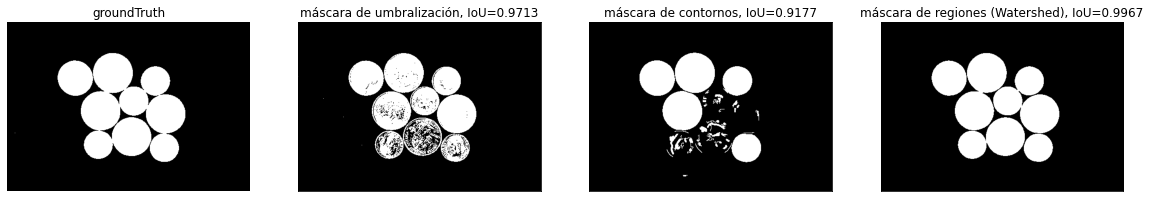

In [8]:
from sklearn.metrics import jaccard_similarity_score
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning) #Para evitar los futureWarnings

groundTruth = io.imread(imgsGroundTruth[indiceImagen])
groundTruth = groundTruth > 1 # Se añade debido a que la conversión a escala de grises introduce ruido en el exterior de las monedas de las imágenes de groundTruth 
groundTruth = (rgb2gray(groundTruth)).astype('uint8')

iouSegUmbralizacion = jaccard_similarity_score(groundTruth.ravel(), mascaraUmbralizacion.ravel())
iouSegContornos =  jaccard_similarity_score(groundTruth.ravel(), mascaraContornos.ravel())
iouSegRegiones =  jaccard_similarity_score(groundTruth.ravel(), mascaraWatershed.ravel())

plt.figure(figsize=(20,20))
plt.subplot(1,4,1),plt.imshow(groundTruth, cmap=plt.cm.gray);plt.title('groundTruth'), plt.axis('off')
plt.subplot(1,4,2),plt.imshow(mascaraUmbralizacion, cmap=plt.cm.gray);plt.title('máscara de umbralización, IoU=%.4f' % iouSegUmbralizacion), plt.xticks([]), plt.yticks([])
plt.subplot(1,4,3),plt.imshow(mascaraContornos, cmap=plt.cm.gray);plt.title('máscara de contornos, IoU=%.4f' % iouSegContornos), plt.xticks([]), plt.yticks([])
plt.subplot(1,4,4),plt.imshow(mascaraWatershed, cmap=plt.cm.gray);plt.title('máscara de regiones (Watershed), IoU=%.4f' % iouSegRegiones), plt.xticks([]), plt.yticks([])
plt.show()

## ``Referencias``
Scikit-learn team (2018). Comparing edge-based and region-based segmentation. Retrieved February 21, 2021, from https://scikit-image.org/docs/stable/auto_examples/applications/plot_coins_segmentation.html

Jiancheng, L., &amp; Scikit-learn team (2015). Sklearn.metrics.jaccard_similarity_score. Retrieved February 21, 2021, from http://lijiancheng0614.github.io/scikit-learn/modules/generated/sklearn.metrics.jaccard_similarity_score.html

Li, J., &amp; Scikit-learn team, (2016). API REFERENCE. Retrieved February 24, 2021, from http://lijiancheng0614.github.io/scikit-learn/modules/classes.html#module-sklearn.metrics

Carson, C., Stein, J., &amp; Sitharaman, S. (2017, July 13). Using sklearn.metrics Jaccard index with images? Retrieved February 23, 2021, from https://stackoverflow.com/questions/45065469/using-sklearn-metrics-jaccard-index-with-images

Desertnaut, Al Nazi, Z., &amp; Mridulrb. (2020, December 08). Why are the outputs of jaccard_score and jaccard_similarity_score different? Retrieved February 24, 2021, from https://stackoverflow.com/questions/61790069/why-are-the-outputs-of-jaccard-score-and-jaccard-similarity-score-different
